In [1]:
import pandas as pd
import ast 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import requests
import joblib
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('/Volumes/Maestria/Maestria/Programs/Machine Learning/Proyecto/neo_data.csv') 
df.head()


,links,id,neo_reference_id,name,name_limited,designation,nasa_jpl_url,absolute_magnitude_h,estimated_diameter,is_potentially_hazardous_asteroid,close_approach_data,orbital_data,is_sentry_object
0,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2000433,2000433,433 Eros (A898 PA),Eros,433,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,10.41,{'kilometers': {'estimated_diameter_min': 22.0...,False,"[{'close_approach_date': '1900-12-27', 'close_...","{'orbit_id': '659', 'orbit_determination_date'...",False
1,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2000719,2000719,719 Albert (A911 TB),Albert,719,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,15.59,{'kilometers': {'estimated_diameter_min': 2.02...,False,"[{'close_approach_date': '1909-08-21', 'close_...","{'orbit_id': '266', 'orbit_determination_date'...",False
2,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2000887,2000887,887 Alinda (A918 AA),Alinda,887,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,13.88,{'kilometers': {'estimated_diameter_min': 4.45...,False,"[{'close_approach_date': '1910-01-04', 'close_...","{'orbit_id': '488', 'orbit_determination_date'...",False
3,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2001036,2001036,1036 Ganymed (A924 UB),Ganymed,1036,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,9.25,{'kilometers': {'estimated_diameter_min': 37.5...,False,"[{'close_approach_date': '1910-02-25', 'close_...","{'orbit_id': '1240', 'orbit_determination_date...",False
4,{'self': 'http://api.nasa.gov/neo/rest/v1/neo/...,2001221,2001221,1221 Amor (1932 EA1),Amor,1221,https://ssd.jpl.nasa.gov/tools/sbdb_lookup.htm...,17.38,{'kilometers': {'estimated_diameter_min': 0.88...,False,"[{'close_approach_date': '1900-03-08', 'close_...","{'orbit_id': '121', 'orbit_determination_date'...",False


In [3]:
# """
# Esto resuelve close_approach_data. Deberia ir antes de cualquier limpieza para tratarlo como un df completito
# """
# # Turn object into list of dicts
# df["close_approach_data"] = df["close_approach_data"].apply(ast.literal_eval)

# # Explode df
# df = df.explode("close_approach_data").reset_index(drop=True)

# normalized_close_approach_data = pd.json_normalize(df['close_approach_data'])
# df = pd.concat([df.drop(columns=['close_approach_data']), normalized_close_approach_data], axis=1)





In [4]:
class OverallProcessor:

    def __init__(self, df):
        self.df = df

    def explode(self):

        def explode_approach(self):
            self.df['close_approach_data'] = self.df['close_approach_data'].apply(ast.literal_eval)
            self.df = self.df.explode("close_approach_data").reset_index(drop=True)
            normalized_close_approach_data = pd.json_normalize(self.df['close_approach_data'])
            self.df = pd.concat([self.df.drop(columns=['close_approach_data']), normalized_close_approach_data], axis=1)
            
        
        def clean_diameter(self):
                self.df.drop(columns=['neo_reference_id', 'name_limited', 'links', 'nasa_jpl_url'], inplace=True)
                self.df['estimated_diameter'] = self.df['estimated_diameter'].str.replace('\'', '')
                self.df['estimated_diameter'] = self.df['estimated_diameter'].str.replace('{', '')
                self.df['estimated_diameter'] = self.df['estimated_diameter'].str.replace('}', '')
                parts = self.df['estimated_diameter'].str.split(',')
                self.df['estimated_diameter'] = parts.str[0] + parts.str[1]
                parts = self.df['estimated_diameter'].str.split(':')
                self.df['estimated_diameter'] = parts.str[1] + parts.str[2] + parts.str[3] 
                parts = self.df['estimated_diameter'].str.split(' ')
                self.df['estimated_diameter_min'] = parts.str[2]
                self.df['estimated_diameter_max'] = parts.str[4]
                self.df.drop(columns=['estimated_diameter'], inplace=True)


        def clean_orbits(self):
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('\'', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('{', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('}', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace(']', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('[', '')
            parts = self.df['orbital_data'].str.split(',')
            self.df['extracted_orbital_data'] = parts.str[7]+parts.str[10]+parts.str[12]+parts.str[15]+parts.str[17]
            parts = self.df['extracted_orbital_data'].str.split(' ')
            self.df['minimum_orbit_intersection'] = parts.str[2]
            self.df['eccentricity'] = parts.str[4]
            self.df['inclination'] = parts.str[6]
            self.df['perihilion_distance'] = parts.str[8]
            self.df['aphelion_distance'] = parts.str[10]
            self.df.drop(columns=['orbital_data', 'extracted_orbital_data'], inplace=True)    

        explode_approach(self)
        clean_diameter(self)
        clean_orbits(self)
        return self.df
    
    def clean(self):

        def explode_approach(self):
            self.df['close_approach_data'] = self.df['close_approach_data'].apply(ast.literal_eval)
            self.df = self.df.explode("close_approach_data").reset_index(drop=True)
            normalized_close_approach_data = pd.json_normalize(self.df['close_approach_data'])
            self.df = pd.concat([self.df.drop(columns=['close_approach_data']), normalized_close_approach_data], axis=1)
            
        
        def clean_diameter(self):
                self.df.drop(columns=['neo_reference_id', 'name_limited', 'links', 'nasa_jpl_url'], inplace=True)
                self.df['estimated_diameter'] = self.df['estimated_diameter'].str.replace('\'', '')
                self.df['estimated_diameter'] = self.df['estimated_diameter'].str.replace('{', '')
                self.df['estimated_diameter'] = self.df['estimated_diameter'].str.replace('}', '')
                parts = self.df['estimated_diameter'].str.split(',')
                self.df['estimated_diameter'] = parts.str[0] + parts.str[1]
                parts = self.df['estimated_diameter'].str.split(':')
                self.df['estimated_diameter'] = parts.str[1] + parts.str[2] + parts.str[3] 
                parts = self.df['estimated_diameter'].str.split(' ')
                self.df['estimated_diameter_min'] = parts.str[2]
                self.df['estimated_diameter_max'] = parts.str[4]
                self.df.drop(columns=['estimated_diameter'], inplace=True)


        def clean_orbits(self):
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('\'', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('{', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('}', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace(']', '')
            self.df['orbital_data'] = self.df['orbital_data'].str.replace('[', '')
            parts = self.df['orbital_data'].str.split(',')
            self.df['extracted_orbital_data'] = parts.str[7]+parts.str[10]+parts.str[12]+parts.str[15]+parts.str[17]
            parts = self.df['extracted_orbital_data'].str.split(' ')
            self.df['minimum_orbit_intersection'] = parts.str[2]
            self.df['eccentricity'] = parts.str[4]
            self.df['inclination'] = parts.str[6]
            self.df['perihilion_distance'] = parts.str[8]
            self.df['aphelion_distance'] = parts.str[10]
            self.df.drop(columns=['orbital_data', 'extracted_orbital_data'], inplace=True)   


        def clean_df(self):
            self.df.drop(columns=['id', 'name', 'designation', 'is_sentry_object', 'close_approach_date', 'close_approach_date_full', 'epoch_date_close_approach', 'orbiting_body', 'relative_velocity.kilometers_per_second', 'relative_velocity.miles_per_hour', 'miss_distance.astronomical', 'miss_distance.lunar', 'miss_distance.miles' ], inplace=True)
            self.df = self.df.rename(columns={'is_potentially_hazardous_asteroid': 'is_hazardous'}) 
            estimated_diameter_average = (self.df['estimated_diameter_min'].astype(float) + self.df['estimated_diameter_max'].astype(float)) / 2
            self.df['estimated_diameter_average'] = estimated_diameter_average

        explode_approach(self)
        clean_diameter(self)
        clean_orbits(self)
        clean_df(self)
        return self.df  
    

In [5]:

df = OverallProcessor(df).clean()
df.head()


,absolute_magnitude_h,is_hazardous,relative_velocity.kilometers_per_hour,miss_distance.kilometers,estimated_diameter_min,estimated_diameter_max,minimum_orbit_intersection,eccentricity,inclination,perihilion_distance,aphelion_distance,estimated_diameter_average
0,10.41,False,20083.0290749201,47112732.928149391,22.0067027115,49.2084832235,.15023,.2226906033843441,10.8277255953075,1.133458052992745,1.782904615277399,35.607593
1,10.41,False,15820.1671985367,70533232.893794475,22.0067027115,49.2084832235,.15023,.2226906033843441,10.8277255953075,1.133458052992745,1.782904615277399,35.607593
2,10.41,False,17340.4224662258,74687814.59975122,22.0067027115,49.2084832235,.15023,.2226906033843441,10.8277255953075,1.133458052992745,1.782904615277399,35.607593
3,10.41,False,16545.797587763,53823292.394218643,22.0067027115,49.2084832235,.15023,.2226906033843441,10.8277255953075,1.133458052992745,1.782904615277399,35.607593
4,10.41,False,21314.9467227704,26040971.835879446,22.0067027115,49.2084832235,.15023,.2226906033843441,10.8277255953075,1.133458052992745,1.782904615277399,35.607593


<Axes: xlabel='is_hazardous', ylabel='Count'>

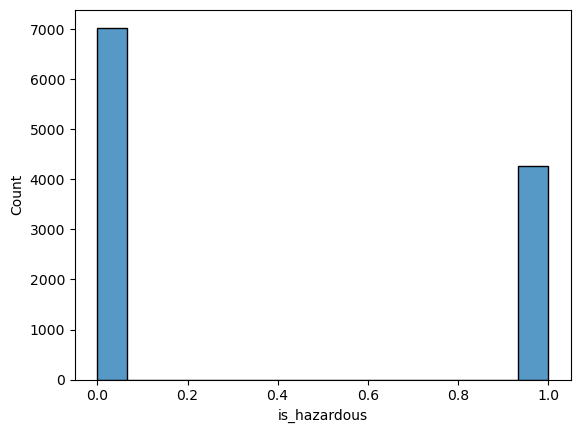

In [6]:
df.shape
sns.histplot(df['is_hazardous'])

In [7]:


df_test = df.copy()

sm = SMOTE(sampling_strategy='minority', random_state=42)

oversampled_X, oversampled_Y = sm.fit_resample(df_test.drop('is_hazardous', axis=1), df_test['is_hazardous'])
df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
df.shape

(14058, 12)

<Axes: xlabel='is_hazardous', ylabel='Count'>

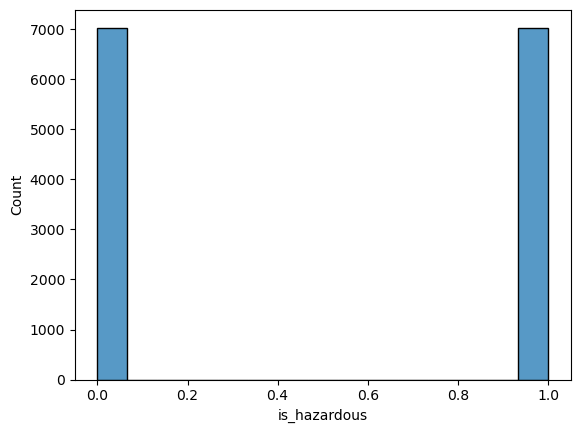

In [8]:
sns.histplot(df['is_hazardous'])

In [166]:
df2 = pd.read_csv('/Volumes/Maestria/Maestria/Programs/Machine Learning/Proyecto/df_2.csv')
df2t = df2.head(1)
df2t = pd.DataFrame(df2t)
df2t



,neo_data
0,{'links': {'self': 'http://api.nasa.gov/neo/re...


,data
1,"[, 'orbital_data': {'orbit_id': '2', 'orbit_..."


,data,links,id,neo_reference_id,name,designation,nasa_jpl_url,absolute_magnitude_h,estimated_diameter,is_potentially_hazardous_asteroid,close_approach_data,orbit_data,sentry_object_data
1,{'links': {'self': 'http://api.nasa.gov/neo/re...,{'links': {'self': 'http://api.nasa.gov/neo/re...,'id': '54292695','neo_reference_id': '54292695','name': '(2022 PA)','designation': '2022 PA','nasa_jpl_url': 'https://ssd.jpl.nasa.gov/too...,'absolute_magnitude_h': 26.06,'estimated_diameter': {'kilometers': {'estima...,'is_potentially_hazardous_asteroid': False,"{'close_approach_date': '1983-08-19', 'close_a...","[, 'orbital_data': {'orbit_id': '2', 'orbit_...",'is_sentry_object': False}
